In [63]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from src.attribution.flextime import Filterbank

In [64]:
# Load and shape synthetic data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# create the dataset
dataset = TensorDataset(x, y)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# check shape of the dataloader
for x, y in test_loader:
    print(x.shape)
    print(y.shape)
    break


(20000, 1, 3000)
(20000,)
torch.Size([128, 1, 3000])
torch.Size([128])


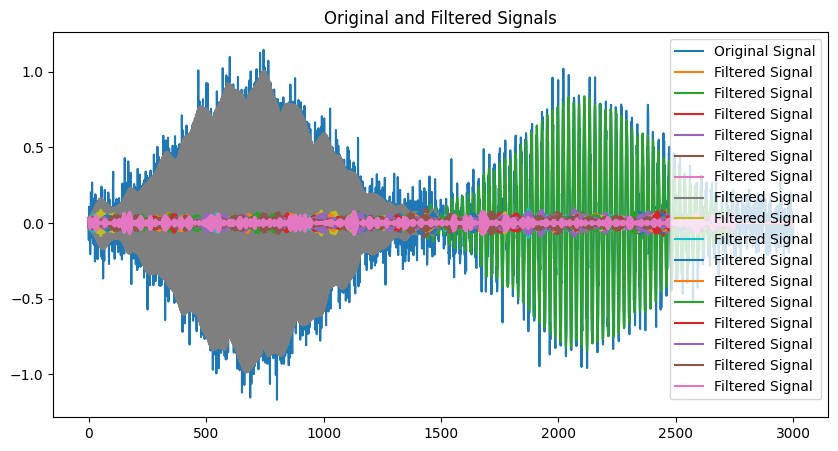

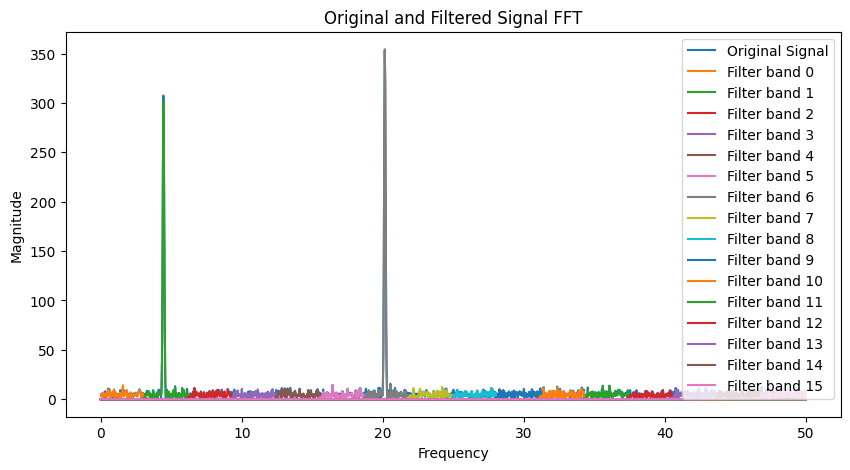

In [65]:
# create the filterbank
filterbank = Filterbank(n_taps=501, n_filters=16, sample_freq=100, time_len=len(x[-1]))
# filterbank.plot_filterbank()

# apply the filter to a sample
for x, y in test_loader:
    # get the first sequence
    x = x[:1]
    filtered_x = filterbank.apply_filterbank(x)

    # plot the original and filtered signals
    plt.figure(figsize=(10, 5))
    plt.plot(x[0][0].numpy(), label="Original Signal")
    plt.plot(filtered_x[0][0], label="Filtered Signal")
    plt.legend()
    plt.title("Original and Filtered Signals")
    plt.show()

    # do the fft to check the frequency response
    sig = x[0][0].numpy()
    filtered_sig = filtered_x[0][0].T
    n = sig.shape[0]
    sample_freq = 1/100
    freqs = np.fft.fftfreq(n, d=sample_freq)

    dft_x = np.fft.fft(sig)
    dft_x = np.abs(dft_x)

    plt.figure(figsize=(10, 5))
    plt.plot(freqs[:len(freqs)//2], dft_x[:len(dft_x)//2], label="Original Signal")

    
    for i in range(len(filtered_sig)):
        dft_filtered_x = np.fft.fft(filtered_sig[i])
        dft_filtered_x = np.abs(dft_filtered_x)

        plt.plot(freqs[:len(freqs)//2], dft_filtered_x[:len(dft_filtered_x)//2], label=f"Filter band {i}")
       

    plt.legend(loc="upper right")
    plt.ylabel("Magnitude")
    plt.xlabel("Frequency")
    plt.title("Original and Filtered Signal FFT")
    plt.show()

    break

In [4]:
# load simpleCNN from checkpoint
from src.models.simple import SimpleCNN

path = "./model/checkpoint/simpleCNN.pth"

# load the model with torch
model = SimpleCNN(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=2, num_classes=2)
model.load_state_dict(torch.load(path, map_location=torch.device('mps')))

<All keys matched successfully>

In [5]:
from src.attribution import compute_attribution
from types import SimpleNamespace

args = SimpleNamespace()
args.n_taps = 501
args.n_filters = 16
args.sample_freq = 100
args.time_len = len(x[-1])

# compute attribution of the masks
masks, scores = compute_attribution('flextime', model, test_loader, device="mps", args=args)

Batch 0 of 157
Sample 0 of 128
Epoch 0 Loss 8.313438415527344
Sample 1 of 128
Epoch 0 Loss 8.314385414123535
Epoch 100 Loss 0.6184659004211426
Sample 2 of 128
Epoch 0 Loss 8.313859939575195
Epoch 100 Loss 0.6064304709434509
Sample 3 of 128
Epoch 0 Loss 8.316235542297363
Epoch 100 Loss 0.6526524424552917
Sample 4 of 128
Epoch 0 Loss 8.314586639404297
Epoch 100 Loss 0.6222641468048096
Sample 5 of 128
Epoch 0 Loss 8.31332015991211
Sample 6 of 128
Epoch 0 Loss 8.31406307220459
Epoch 100 Loss 0.617136538028717
Sample 7 of 128
Epoch 0 Loss 8.313556671142578
Sample 8 of 128
Epoch 0 Loss 8.322578430175781
Epoch 100 Loss 0.6794486045837402
Sample 9 of 128
Epoch 0 Loss 8.31376838684082
Sample 10 of 128
Epoch 0 Loss 8.313308715820312
Sample 11 of 128
Epoch 0 Loss 8.320348739624023
Epoch 100 Loss 0.6601699590682983
Sample 12 of 128
Epoch 0 Loss 8.314833641052246
Epoch 100 Loss 0.62789386510849
Sample 13 of 128
Epoch 0 Loss 8.314924240112305
Epoch 100 Loss 0.6284778118133545
Sample 14 of 128
Epoch 

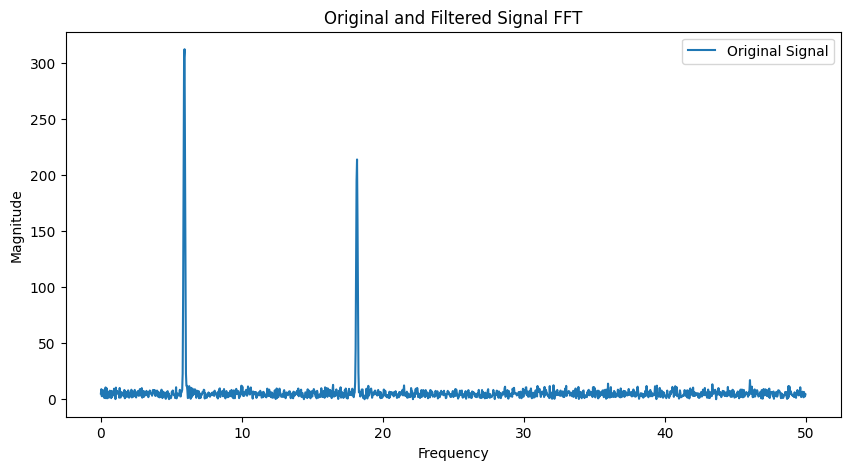

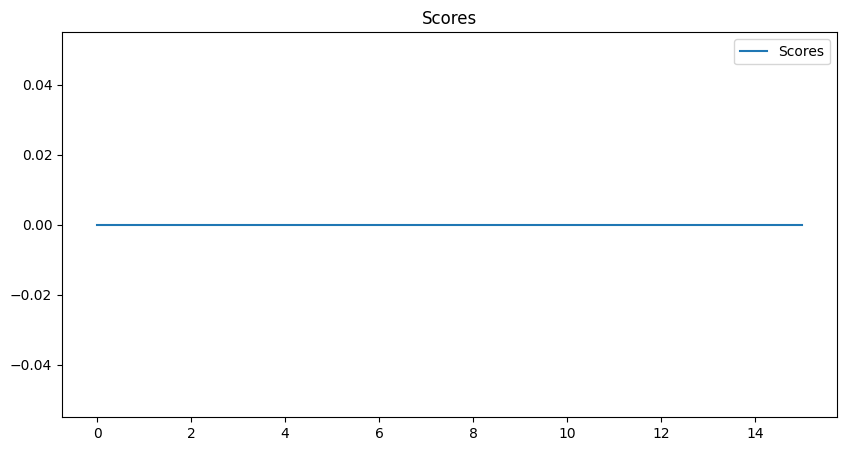

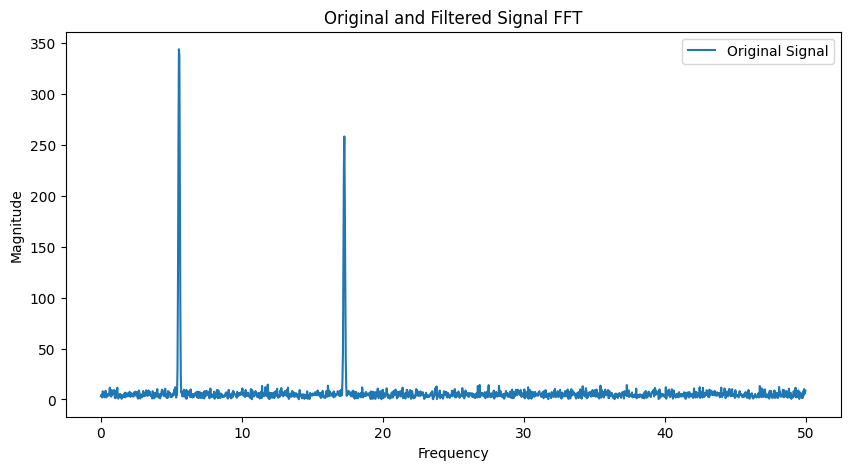

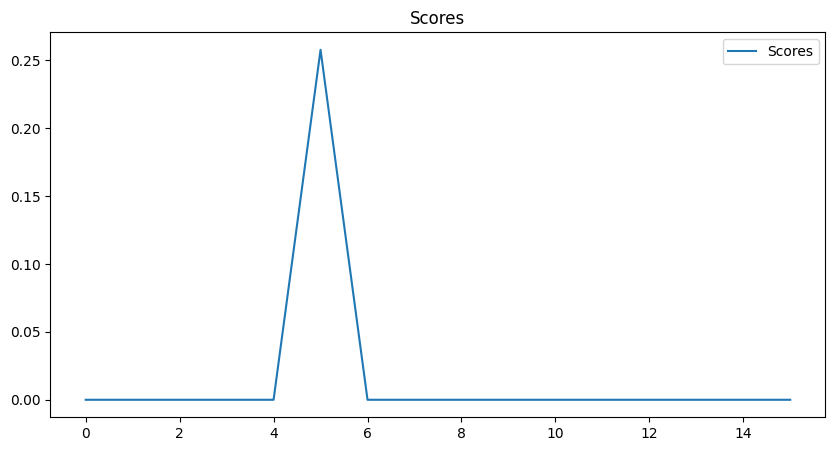

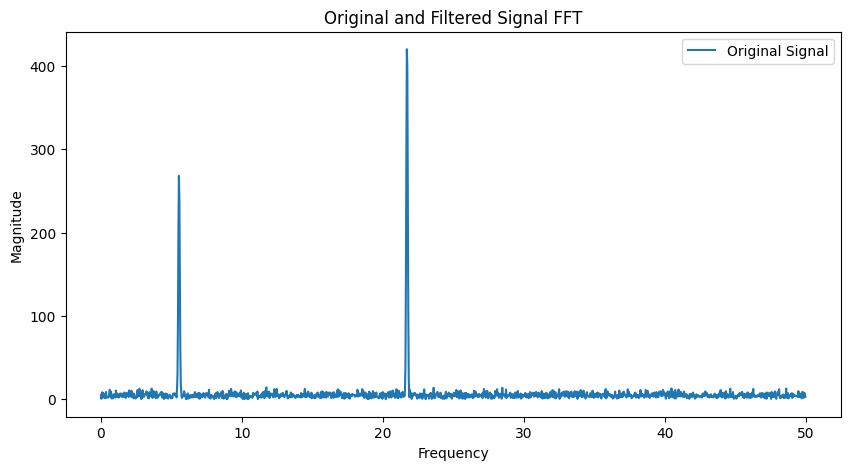

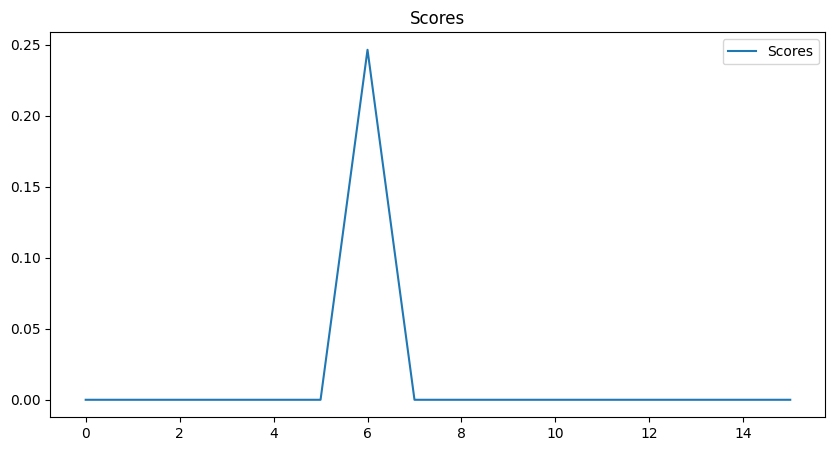

In [24]:
# first sequence
for x, y in test_loader:

    # get first batch of masks
    # print(len(masks)) # shape (157, 128, 1, 1) - n_batches, batch_size, normalized_mask
    mask_batch = masks[0] # shape (128, 1, 1) - batch_size, normalized_mask

    # scores shape
    # print(len(scores)) # shape (157, 128, 16) - n_batches, batch_size, n_filters

    for i in range(len(x)):
        if i > 2 :
            break

        # plot the first mask
        # filterbank.plot_filter_response(mask=mask_batch[i].numpy())

        # plot the signal in the frequency domain
        sig = x[i][0].numpy()
        n = sig.shape[0]
        sample_freq = 1/100
        freqs = np.fft.fftfreq(n, d=sample_freq)
        dft_x = np.fft.fft(sig)
        dft_x = np.abs(dft_x)

        plt.figure(figsize=(10, 5))
        plt.plot(freqs[:len(freqs)//2], dft_x[:len(dft_x)//2], label="Original Signal")
        plt.legend(loc="upper right")
        plt.ylabel("Magnitude")
        plt.xlabel("Frequency")
        plt.title("Original and Filtered Signal FFT")
        plt.show()

        # plot the scores
        plt.figure(figsize=(10, 5))
        plt.plot(scores[0][i], label="Scores")
        plt.legend()
        plt.title("Scores")
        plt.show()

    break

    


In [22]:
from scipy.signal import spectrogram

def plot_freq_heatmap(signal, attribution, fs=100, nperseg=256, noverlap=128):
    # Compute spectrogram using SciPy
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Convert power to dB scale

    # Normalize attribution scores to match frequency bins
    attr_resized = np.interp(np.linspace(0, len(f)-1, len(attribution)), np.arange(len(attribution)), attribution)

    # Plot spectrogram with overlayed heatmap
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='inferno')
    plt.imshow(attr_resized[:, None], aspect='auto', alpha=0.6, cmap='jet', origin='lower', extent=[t.min(), t.max(), f.min(), f.max()])
    plt.colorbar(label="Attribution Score")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Attribution Heatmap over Spectrogram")
    plt.show()

In [ ]:
from scipy.fftpack import fft, fftfreq

def plot_freq_heatmap(signal, attribution, fs=100):
    # Compute FFT
    N = len(signal)
    freq = fftfreq(N, d=1/fs)  # Frequency bins
    magnitude = np.abs(fft(signal))  # Magnitude of FFT

    # Keep only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    magnitude = magnitude[pos_mask]

    # Normalize attribution scores to [0,1]
    attr_resized = np.interp(freq, np.linspace(freq.min(), freq.max(), len(attribution)), attribution)
    attr_norm = (attr_resized - np.min(attr_resized)) / (np.max(attr_resized) - np.min(attr_resized) + 1e-10)

    # Create a 2D grid for heatmap
    freq_grid, mag_grid = np.meshgrid(freq, magnitude)
    attr_grid = np.tile(attr_norm[:-1], (len(magnitude) - 1, 1))  # Repeat attribution scores along the magnitude axis

    # Plot heatmap
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude, label="FFT Magnitude", color='black', alpha=0.6)
    plt.pcolormesh(freq_grid, mag_grid, attr_grid, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.title("Attribution Heatmap in Frequency Domain")
    plt.show()

    # save the figure
    plt.savefig("attribution_heatmap.png")


(128, 1, 3000)


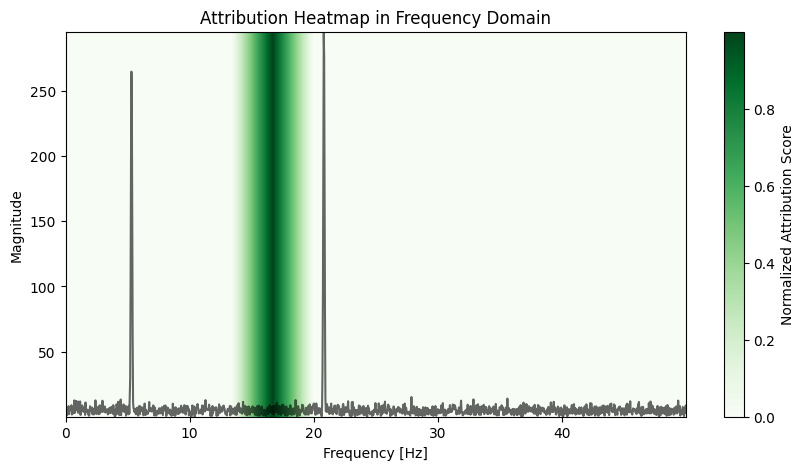

In [59]:
# plot the scores as a heatmap on the original signal
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()
    print(x.shape)
    filtered_x = filterbank.apply_filterbank(x)

    plot_freq_heatmap(x[1][0], scores[0][1])
    break

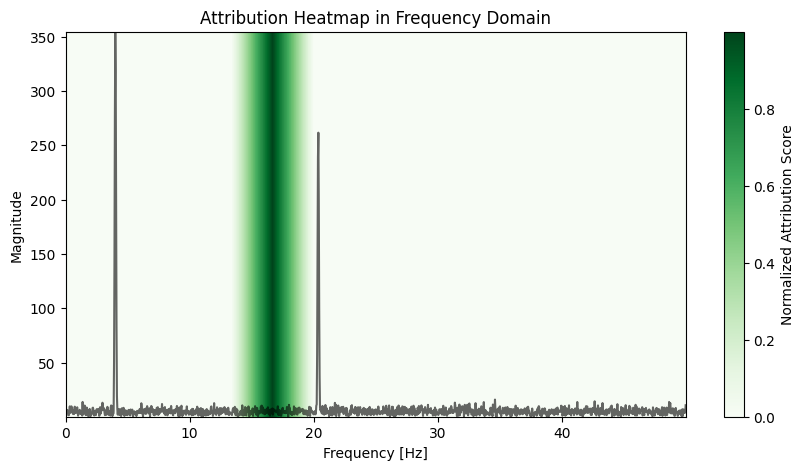

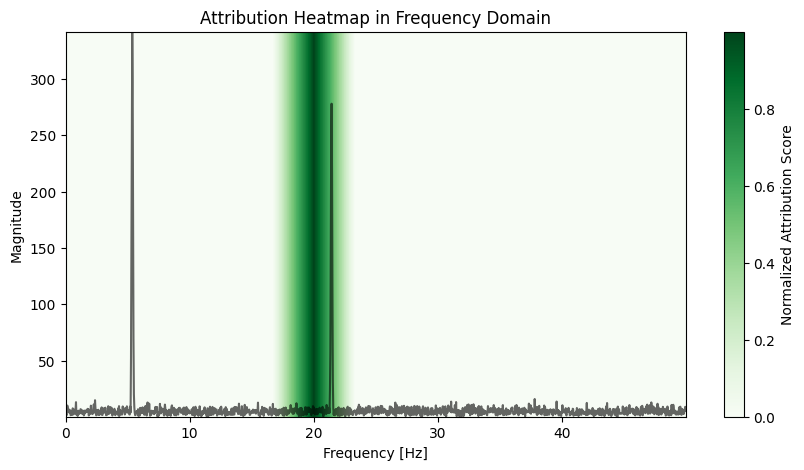

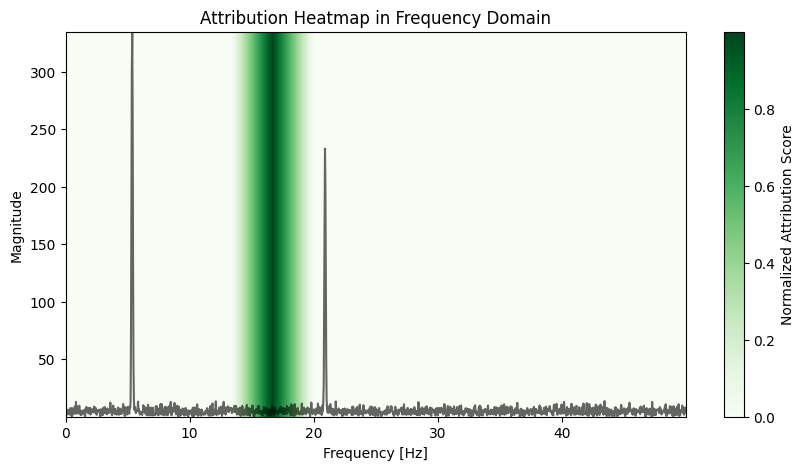

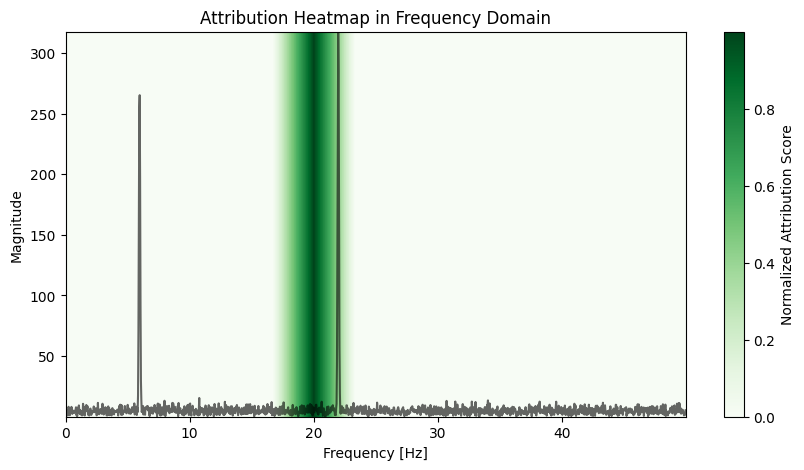

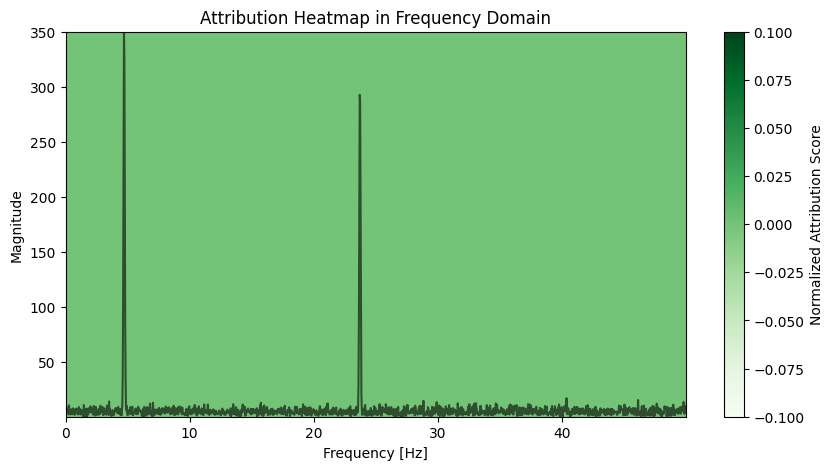

In [60]:
# plot the scores as a heatmap on the original signal
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()

    # plot 5 samples
    for i in range(1, 6):
        plot_freq_heatmap(x[i][0], scores[0][i])
    break

In [62]:
import pickle

# save the masks
# with open("public/masks_2.pkl", "wb") as f:
#     pickle.dump(masks, f)

# save the scores
with open("public/scores_2.pkl", "wb") as f:
    pickle.dump(scores, f)

In [80]:
import pywt
import math

def plot_dwt_scaleogram_lvl(coeffs, x, fs, level):
    """
    Plot the scaleogram of the Discrete Wavelet Transform (DWT).

    Parameters:
    coeffs (list): List of DWT coefficients from pywt.wavedec.
    x (np.ndarray): Original signal.
    fs (float): Sampling frequency of the signal.
    level (int): Number of decomposition levels.
    """
    # Compute the time axis
    time = np.linspace(0, len(x) / fs, len(x))

    # Prepare the scaleogram
    scaleogram = []
    for i, coeff in enumerate(coeffs):
        factor = math.ceil(len(x)/len(coeff))
        # Upsample coefficients to match the original signal length
        upsampled = np.repeat(coeff, factor)[:len(x)]
        scaleogram.append(upsampled)
    scaleogram = np.array(scaleogram)
    scaleogram = scaleogram[:, :(len(x))-1]

    # Calculate the frequencies for each level (scales are powers of 2, so freqs are powers of 2)
    freqs_dwt = np.logspace(start=0, stop=level+1, num=level+2, base=2)

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freqs_dwt, np.abs(scaleogram), cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title('DWT Scaleogram')
    plt.yscale('log', base=2)
    plt.yticks(ticks=freqs_dwt, labels=[f'{int(i)}' for i in range(len(freqs_dwt))])
    plt.xlabel('Time (s)')
    plt.ylabel('Decomposition Level')
    plt.show()



In [ ]:
import pywt
import math

def plot_dwt_scaleogram_freq(coeffs, x, fs, level, time=None):
    """
    Plot the scaleogram of the Discrete Wavelet Transform (DWT).

    Parameters:
    coeffs (list): List of DWT coefficients from pywt.wavedec.
    x (np.ndarray): Original signal.
    fs (float): Sampling frequency of the signal.
    level (int): Number of decomposition levels.
    time (np.ndarray): Time axis of the signal.
    """
    # Compute the time axis
    if time is None:
        time = np.linspace(0, len(x) / fs, len(x))

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
    freq_bands.append(fs / (2 ** level))                        # Nyquist
    freq_bands.append(0)                                        # lowest frequency
    print(freq_bands)

    # flip the frequency bands
    freq_bands = freq_bands[::-1]

    # Prepare the scaleogram
    scaleogram = []
    for i, coeff in enumerate(coeffs):
        factor = math.ceil(len(x)/len(coeff))
        # Upsample coefficients to match the original signal length
        upsampled = np.repeat(coeff, factor)[:len(x)]
        scaleogram.append(upsampled)
    scaleogram = np.array(scaleogram)
    scaleogram = scaleogram[:, :(len(x))-1]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, np.abs(scaleogram), cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title('DWT Scaleogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

[  1.   2.   4.   8.  16.  32.  64. 128.]


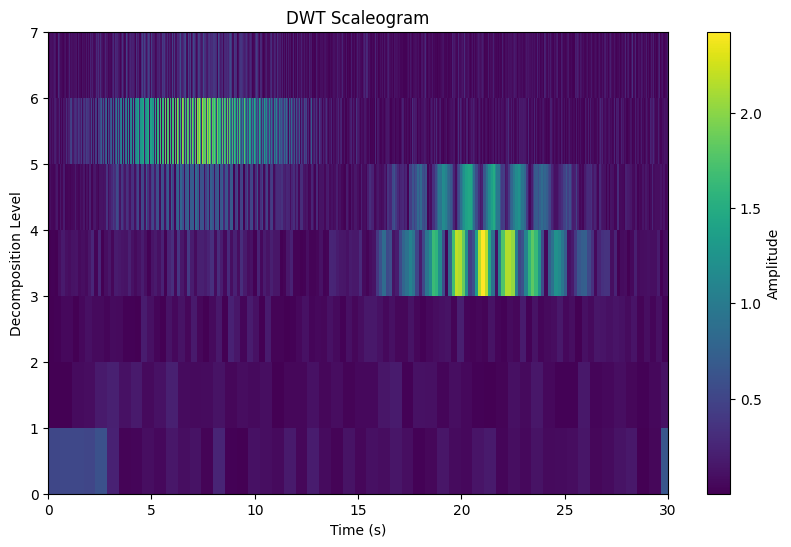

In [79]:
level = 6  # Decomposition level
fs = 100  # Sampling frequency
coeffs = pywt.wavedec(sig, 'db4', level=level)  # Compute DWT coefficients
plot_dwt_scaleogram_lvl(coeffs, sig, fs, level)

[50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 1.5625, 0]


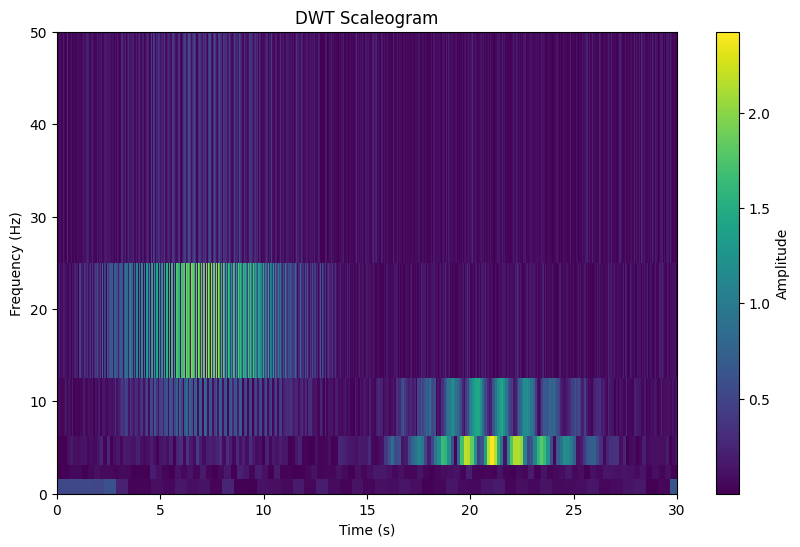

In [67]:
plot_dwt_scaleogram_freq(coeffs, sig, fs, level)

6


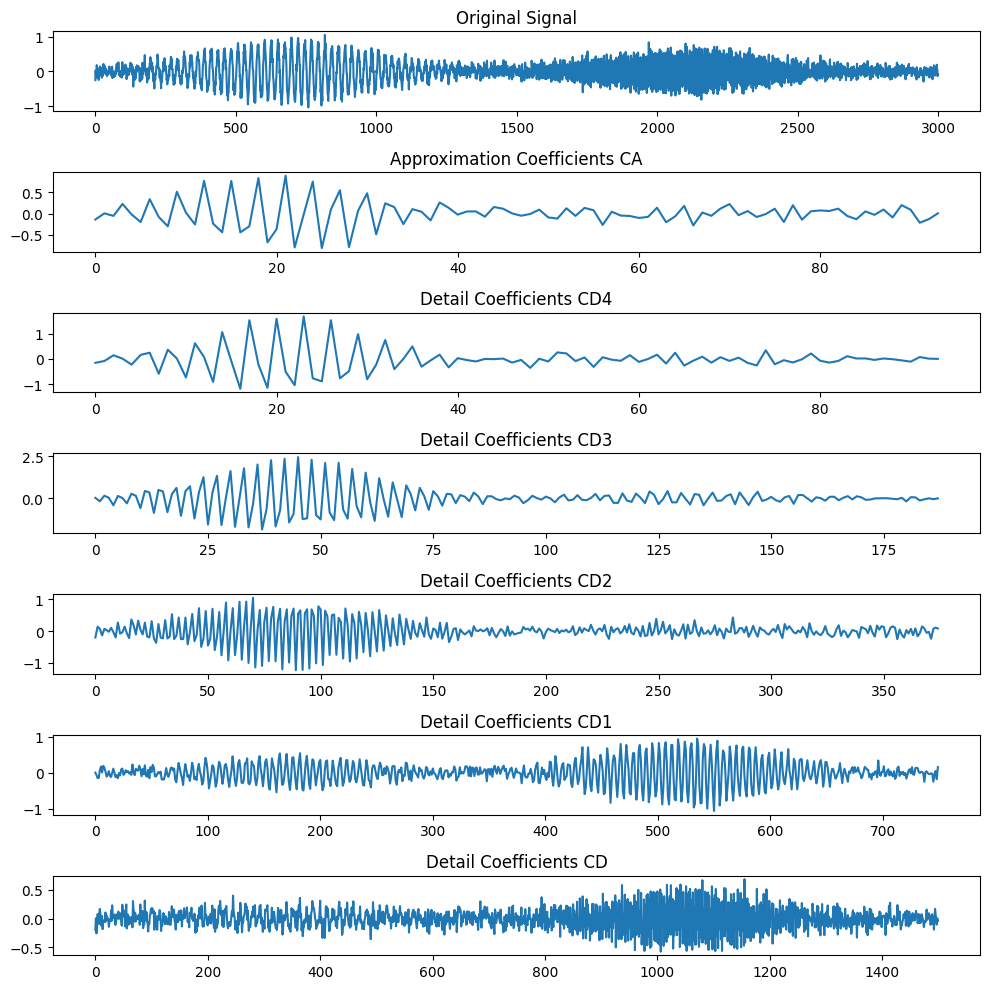

Slices [slice(None, 94, None), {'d': slice(94, 188, None)}, {'d': slice(188, 376, None)}, {'d': slice(376, 751, None)}, {'d': slice(751, 1501, None)}, {'d': slice(1501, 3001, None)}]
shape [(94,), {'d': (94,)}, {'d': (188,)}, {'d': (375,)}, {'d': (750,)}, {'d': (1500,)}]


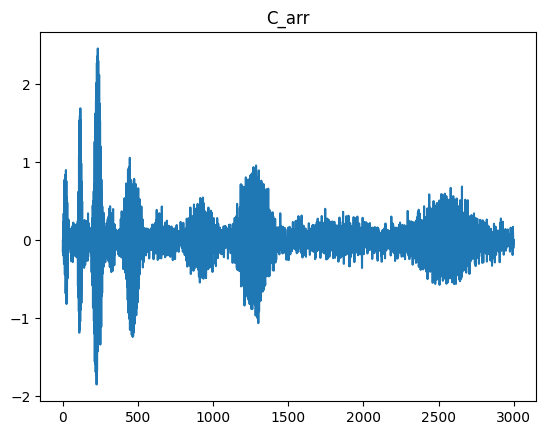

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# # Generate a sample signal

# Perform multi-level DWT
level = 5  # Decomposition level
wavelet = 'db1'  # Choose a Daubechies wavelet
coeffs = pywt.wavedec(sig, 'db1', level=level)  # Compute DWT coefficients
print(len(coeffs))
ca, cd5, cd4, cd3, cd2, cd1, cd = pywt.wavedec(sig, wavelet, level=level)

# Plot the original signal and DWT coefficients
fig, axes = plt.subplots(8, 1, figsize=(10, 10))

axes[0].plot(sig, label="Original Signal")
axes[0].set_title("Original Signal")

axes[1].plot(ca, label="Approximation Coefficients (CA)")
axes[1].set_title("Approximation Coefficients CA")

axes[2].plot(cd3, label="Detail Coefficients (CD4)")
axes[2].set_title("Detail Coefficients CD4")

axes[3].plot(cd2, label="Detail Coefficients (CD3)")
axes[3].set_title("Detail Coefficients CD3")

axes[4].plot(cd2, label="Detail Coefficients (CD2)")
axes[4].set_title("Detail Coefficients CD2")

axes[5].plot(cd1, label="Detail Coefficients (CD1)")
axes[5].set_title("Detail Coefficients CD1")

axes[6].plot(cd, label="Detail Coefficients (CD)")
axes[6].set_title("Detail Coefficients CD")


plt.tight_layout()
plt.show()

c_arr, c_slices, c_shapes = pywt.ravel_coeffs(coeffs)

print(f"Slices {c_slices}")
print(f"shape {c_shapes}")

# plot the c_arr
plt.figure()
plt.plot(c_arr)
plt.title("C_arr")
plt.show()

In [70]:
import pickle
import importlib
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import fft, fftfreq
from src.attribution.flextime.filterbank import Filterbank

from physioex.physioex.data import PhysioExDataModule

target_package = "physioex.train.networks.utils.target_transform"
target_class = "get_mid_label"
target = getattr(importlib.import_module(target_package), target_class)

datamodule = PhysioExDataModule(
    datasets=["sleepedf"],     # list of datasets to be used
    batch_size=128,            # batch size for the DataLoader
    preprocessing="raw",       # preprocessing method
    selected_channels=["EEG"], # channels to be selected
    sequence_length=7,         # length of the sequence
    target_transform= target,  # since seq to epoch, target seq
    num_workers = 10,          # number of parallel workers
    data_folder = "data"    # path to the data folder
)

# get the test DataLoaders
test_loader = datamodule.test_dataloader()

/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [76]:
# create the filterbank
filterbank = Filterbank(n_taps=501, n_filters=16, sample_freq=100, time_len=3000)
# filterbank.plot_filterbank()

# apply the filter to a sample
for x, y in test_loader:
    # get the first sequence
    x = x[:1]
    filtered_x = filterbank.apply_filterbank(x)

    x_n = x.numpy()
    print(x_n.shape)
    print(filtered_x.shape)

    break

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 560, in rebuild_storage_filename
    storage = torch.UntypedStorage._new_shared_filename_cpu(manager, handle, size)
RuntimeError: Connection refused


KeyboardInterrupt: 

In [75]:
# create the filterbank
filterbank = Filterbank(n_taps=501, n_filters=16, sample_freq=100, time_len=3000)
# filterbank.plot_filterbank()

# apply the filter to a sample
for x, y in test_loader:
    # get the first sequence
    x = x[:1]
    filtered_x = filterbank.apply_filterbank(x)

    x_n = x.numpy()
    print(x_n.shape)
    print(filtered_x.shape)

    break

    # # plot the original and filtered signals
    # plt.figure(figsize=(10, 5))
    # plt.plot(x[0][0].numpy(), label="Original Signal")
    # plt.plot(filtered_x[0][0], label="Filtered Signal")
    # plt.legend()
    # plt.title("Original and Filtered Signals")
    # plt.savefig("public/plots/sample_signal_filtered_time.png")
    # plt.close()

    # # do the fft to check the frequency response
    # sig = x[0][0].numpy()
    # filtered_sig = filtered_x[0][0].T
    # n = sig.shape[0]
    # sample_freq = 1/100
    # freqs = np.fft.fftfreq(n, d=sample_freq)

    # dft_x = np.fft.fft(sig)
    # dft_x = np.abs(dft_x)

    # plt.figure(figsize=(10, 5))
    # plt.plot(freqs[:len(freqs)//2], dft_x[:len(dft_x)//2], label="Original Signal")

    
    # for i in range(len(filtered_sig)):
    #     dft_filtered_x = np.fft.fft(filtered_sig[i])
    #     dft_filtered_x = np.abs(dft_filtered_x)

    #     plt.plot(freqs[:len(freqs)//2], dft_filtered_x[:len(dft_filtered_x)//2], label=f"Filter band {i}")
       

    # plt.legend(loc="upper right")
    # plt.ylabel("Magnitude")
    # plt.xlabel("Frequency")
    # plt.title("Original and Filtered Signal FFT")
    # plt.savefig("public/plots/sample_signal_filtered_freq.png")
    # plt.close()

    # break

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 560, in rebuild_storage_filename
    storage = torch.UntypedStorage._new_shared_filename_cpu(manager, handle, size)
RuntimeError: Connection refused


KeyboardInterrupt: 